# ANN to Predict Valence, Regression

Trying this again, multiple categories, clamp

Setup: Javascript and ipynb stuff

In [60]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [61]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

## Load Functions

In [2]:
from fastai.vision import *
import os
import numpy as np
import pandas as pd
import pickle
import random
from sklearn import preprocessing

In [3]:
path=pathlib.Path('/media/tris/tris_files/EEG_datasets/DMD')
path

PosixPath('/media/tris/tris_files/EEG_datasets/DMD')

## Load Original Data Labels

In [11]:
path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s01.dat'
df_read = pickle.load(open(path, 'rb'), encoding='latin1')
labels=df_read['labels']
df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
df=df_tmp
for n in range (2,10):
    path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s0'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True)
for n in range (10,33):
    path = '/media/tris/tris_files/EEG_datasets/DEAP_data_preprocessed_python/s'+str(n)+'.dat'
    df_read = pickle.load(open(path, 'rb'), encoding='latin1')
    labels=df_read['labels']
    df_tmp = pd.DataFrame(labels, columns=['valence','arousal','dominance','liking'])
    df=df.append(df_tmp, ignore_index=True) 

In [12]:
filenames=[]
subject_labels=[]
for n in range (0,9):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
for n in range (9,32):
    for i in range (0,9):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
    for i in range (9,40):
        filename='S'+str(n+1)+'T'+str(i+1)
        filenames.append(filename)
        subject_label=n+1
        subject_labels.append(subject_label)
df['file_name']=filenames
df['subject_label']=subject_labels
# df=df[['file_name','valence','arousal','dominance','liking']]
df=df[['file_name','subject_label','valence','dominance','arousal']]
df.tail()

,file_name,subject_label,valence,dominance,arousal
1275,S32T36,32,3.91,5.82,6.96
1276,S32T37,32,2.81,6.06,6.13
1277,S32T38,32,3.05,5.10,7.01
1278,S32T39,32,3.99,4.85,7.17
1279,S32T40,32,7.15,9.00,4.03


In [64]:
valence = df[['valence']].values.astype(float)
dominance = df[['dominance']].values.astype(float)
arousal = df[['arousal']].values.astype(float)

min_max_scaler = preprocessing.MinMaxScaler()
v_scaled = min_max_scaler.fit_transform(valence)
d_scaled = min_max_scaler.fit_transform(dominance)
a_scaled = min_max_scaler.fit_transform(arousal)

v_normalized = pd.DataFrame(v_scaled, columns=['v_normal'])
d_normalized = pd.DataFrame(d_scaled, columns=['d_normal'])
a_normalized = pd.DataFrame(a_scaled, columns=['a_normal'])

df_learn=pd.concat([df[['file_name']],v_normalized,d_normalized,a_normalized], axis=1)
df_learn.head()

,file_name,v_normal,d_normal,a_normal
0,S1T1,0.875,0.750,0.875
1,S1T2,0.875,0.750,0.750
2,S1T3,1.000,1.000,0.875
3,S1T4,0.500,0.625,0.625
4,S1T5,0.750,0.750,0.375


In [65]:
path=pathlib.Path('/media/tris/tris_files/EEG_datasets/DMD')
path

PosixPath('/media/tris/tris_files/EEG_datasets/DMD')

In [68]:
df_learn.to_csv(path/'labels_proc_all.csv', index=False)

# Load df labels

In [4]:
path=pathlib.Path('/media/tris/tris_files/EEG_datasets/DMD')
df = pd.read_csv(path/'labels_proc_all.csv') #load labels
df.tail()

,file_name,v_normal,d_normal,a_normal
1275,S32T36,0.375,0.625,0.750
1276,S32T37,0.250,0.625,0.625
1277,S32T38,0.250,0.500,0.750
1278,S32T39,0.375,0.500,0.750
1279,S32T40,0.750,1.000,0.375


## Data loader

In [25]:
src = (ImageList.from_csv(path, 'labels_proc_all.csv', folder='heatmaps_32ch', suffix='.png')
       .split_by_rand_pct(0.2)
       .label_from_df(cols=['v_normal','a_normal','d_normal'],label_cls=FloatList))

In [26]:
tfms=[]

In [27]:
data = (src.transform(tfms, size=400)
        .databunch(bs=5).normalize())

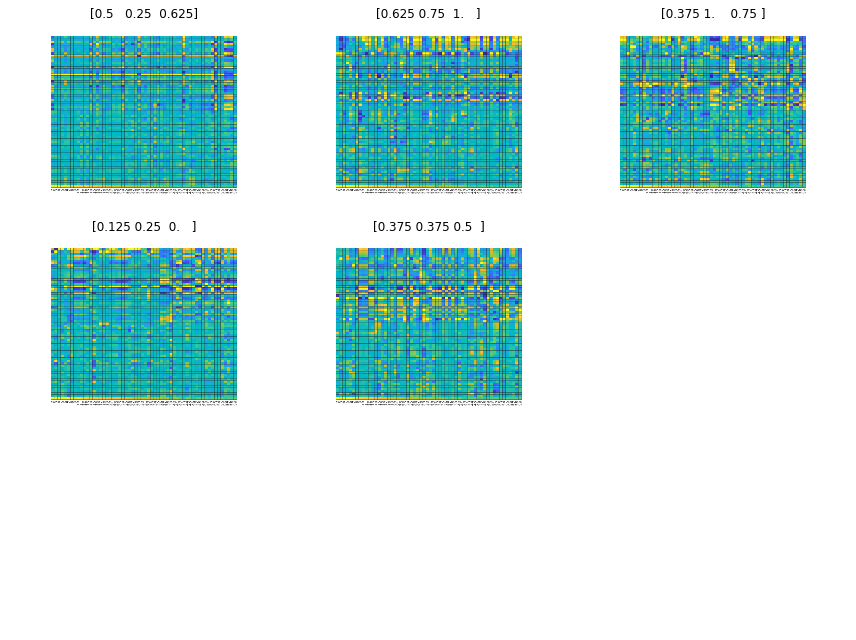

In [28]:
data.show_batch(rows=4, figsize=(12,9))

## Setup Network

In [45]:
learn = cnn_learner(data, models.resnet152, metrics=[root_mean_squared_error,r2_score])
# ymin = 0
# ymax = 1

# class clampedReLU(nn.Module):
#     def forward(self, input):
#         bottomClamp = input < ymin
#         topClamp = input > ymax
#         input[bottomClamp,] = ymin
#         input[topClamp,] = ymax
#         return input

# learn = cnn_learner(data,
#                     models.densenet121, 
#                     metrics=[root_mean_squared_error,r2_score])

# learn.model[1].add_module("cReLU", module= clampedReLU())
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/tris/.cache/torch/checkpoints/resnet152-b121ed2d.pth


Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 200, 200]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 200, 200]       128        True      
______________________________________________________________________
ReLU                 [64, 200, 200]       0          False     
______________________________________________________________________
MaxPool2d            [64, 100, 100]       0          False     
______________________________________________________________________
Conv2d               [64, 100, 100]       4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 100, 100]       128        True      
______________________________________________________________________
Conv2d               [64, 100, 100]       36,864     False     
___________________________________________________

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


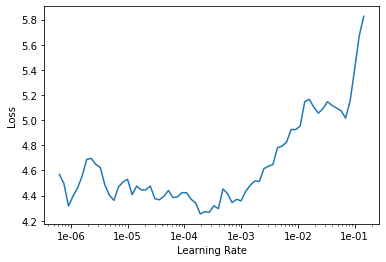

In [46]:
learn.lr_find()
learn.recorder.plot()

## Train last layers

In [47]:
lr = 2e-4
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,4.266301,1.399389,1.158068,-25.926250,01:06
1,3.295527,1.289552,1.121954,-23.974346,01:06
2,2.865868,1.022595,0.995076,-18.952049,01:06
3,2.509706,0.778638,0.866062,-13.701243,01:06
4,2.461204,0.768317,0.862456,-13.616221,01:06


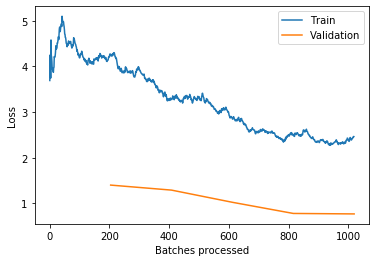

In [48]:
learn.recorder.plot_losses()

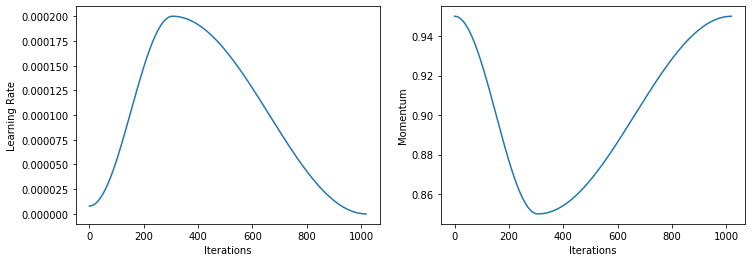

In [49]:
learn.recorder.plot_lr(show_moms=True)

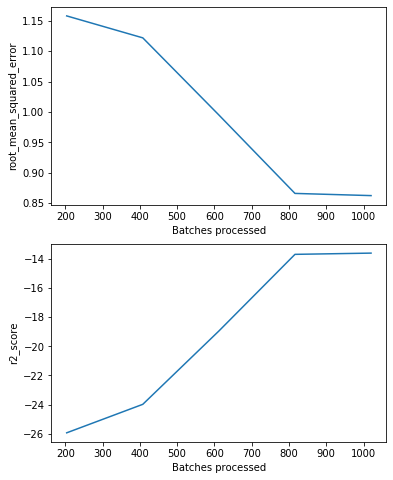

In [50]:
 learn.recorder.plot_metrics() 

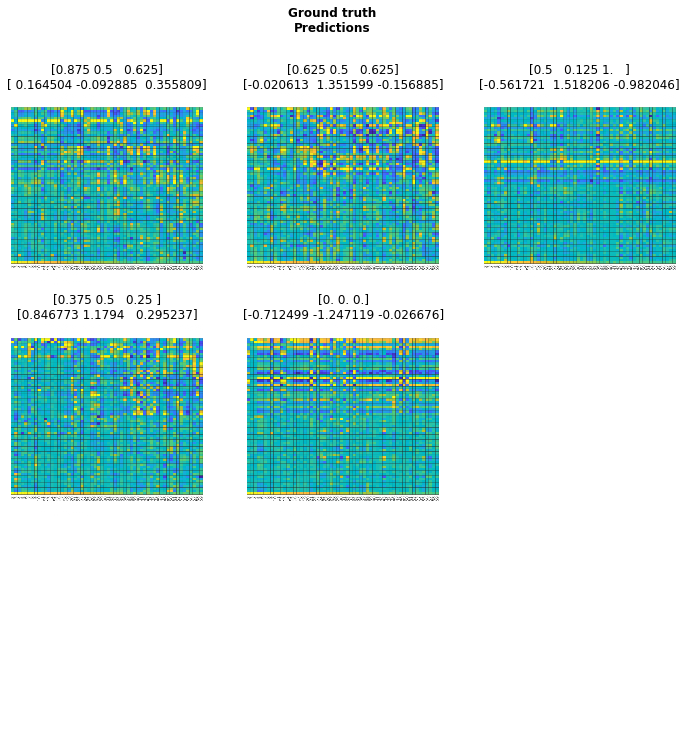

In [51]:
learn.show_results()

## Train the whole network

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


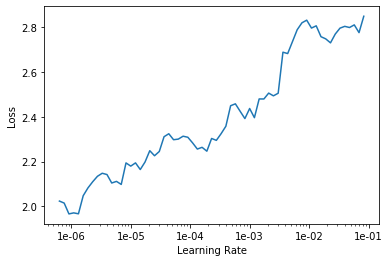

In [52]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [53]:
lr = 2e-6
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,2.329704,0.708236,0.830901,-12.434316,01:28
1,2.366163,0.725552,0.837513,-12.772931,01:28
2,2.466235,0.747895,0.852869,-13.561598,01:28
3,2.485099,0.665771,0.801316,-11.659945,01:28
4,2.435724,0.665412,0.800138,-11.515739,01:29


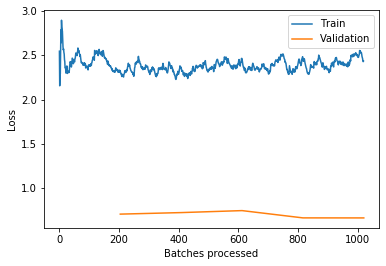

In [54]:
learn.recorder.plot_losses()

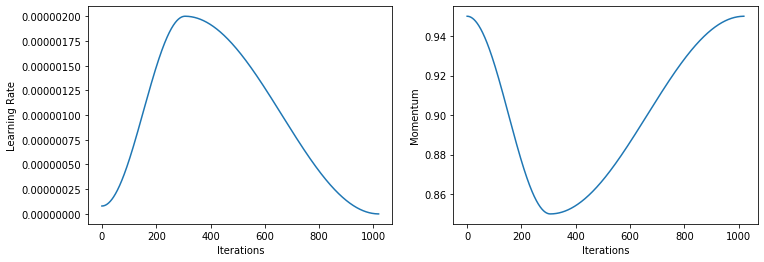

In [55]:
learn.recorder.plot_lr(show_moms=True)

In [56]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,r2_score,time
0,2.394220,0.699154,0.821153,-12.207344,01:27
1,2.248475,0.721303,0.834653,-12.408855,01:28
2,2.485621,0.688512,0.815443,-12.030701,01:28
3,2.398782,0.712341,0.826917,-12.509633,01:28
4,2.416819,0.666259,0.803970,-11.616367,01:28


## Interpret and Results

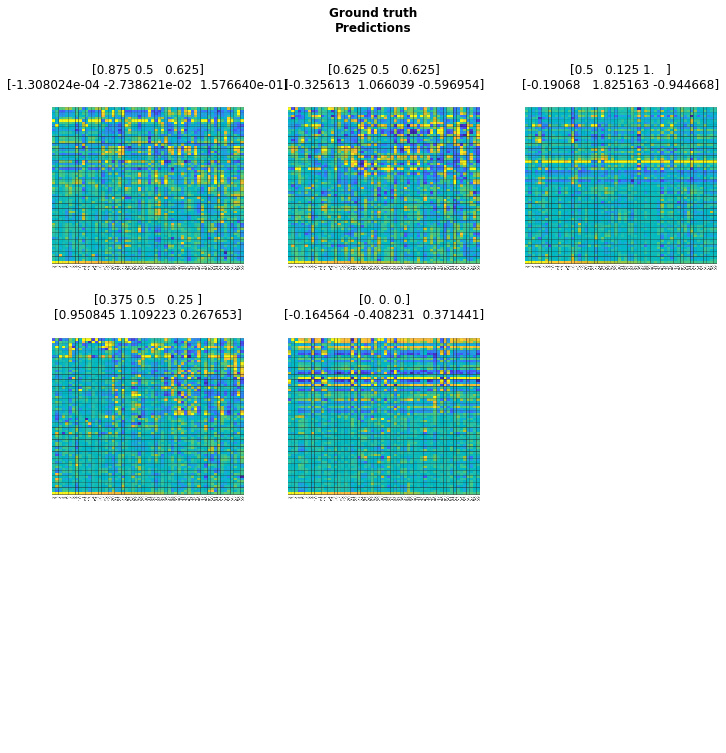

In [57]:
learn.show_results()

Look at this r-score ouch